Exploring Segregation in NYC SChools
==================================



In [1]:

# load the demographic data
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import chi2

import numpy as np
from functools import partial

import scipy
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from IPython.display import Markdown as md, HTML
from nycschools import schools, geo, ui, class_size


In [38]:
# load the demographic data and shape data
df = schools.load_school_demographics()
# school_loc = geo.load_school_locations()
# districts = geo.load_districts()
# size = class_size.load_class_size()


Index of dissimilarity
----------------------

`D` is the _index of dissimilarity_ which is an "index of unevenness segregation." For our data D measures the unevenness of ethnic/racial distribution across schools. Higher values of D indicate that groups are not spread evenly across schools (higher segregation), lower values indicate an even distribution of the population. 1 would be perfectly segregated while 0 would be perfectly proportionate distribution. Below we calculate D for each district and then for the entire school system. We find that some districts have a low D index, where it is higher than the city index in other districts.

**Sources**

- Allen, R., & Vignoles, A. (2007). What should an index of school segregation measure? _Oxford Review of Education_, 33(5), 643–668.\
  <https://doiorg/10.1080/03054980701366306>
- Frankel, D. M., & Volij, O. (2011). Measuring school segregation. _Journal of Economic Theory_, _146_(1), 1–38.\
  <https://doi.org/10.1016/j.jet.2010.10.008>


In [51]:
# calculate unevenness

def calculate_dissimilarity(data):
    total_black = data['black_n'].sum()
    total_white = data['white_n'].sum()
    total_asian = data['asian_n'].sum()
    total_hispanic = data['hispanic_n'].sum()

    total = data.total_enrollment.sum()

    non_black = total - total_black
    non_white = total - total_white
    non_asian = total - total_asian
    non_hispanic = total - total_hispanic

    def diss(row, eth, eth_total, total):
        cols = list(row.index)
        non_eth = sum([row[col] for col in cols if col != eth and col.endswith('_n')])
        D = (row[eth] / eth_total) - (non_eth / total)
        return abs(D)

    black_D = data.apply(partial(diss, eth="black_n", eth_total=total_black, total=non_black), axis=1)
    black_D = black_D.sum() / 2

    white_D = data.apply(partial(diss, eth="white_n", eth_total=total_white, total=non_white), axis=1)
    white_D = white_D.sum() / 2

    asian_D = data.apply(partial(diss, eth="asian_n", eth_total=total_asian, total=non_asian), axis=1)
    asian_D = asian_D.sum() / 2

    hispanic_D = data.apply(partial(diss, eth="hispanic_n", eth_total=total_hispanic, total=non_hispanic), axis=1)
    hispanic_D = hispanic_D.sum() / 2
    weights = [data.asian_pct.mean(), data.black_pct.mean(), data.hispanic_pct.mean(), data.white_pct.mean()]
    D = np.average([asian_D, black_D, hispanic_D, white_D], weights=weights)
    return D

cols = ['dbn', 'district', 'boro', 'total_enrollment', 'black_n', 'white_n', 'asian_n',
        'hispanic_n', 'black_pct', 'white_pct', 'asian_pct', 'hispanic_pct']
data = df[cols].copy()
data.set_index('dbn', inplace=True)
seg_D = pd.DataFrame()
seg_D['district'] = data.district.unique()
seg_D['D'] = seg_D.district.apply(lambda x: calculate_dissimilarity(data[data.district == x]))
nyc_D = calculate_dissimilarity(data)
seg_D = seg_D.sort_values('D', ascending=False)
print("City D", nyc_D)

City D 0.4951746899047429


In [67]:
agg = {
    'boro': 'first',
    'total_enrollment': 'sum',
    'black_n': 'sum',
    'white_n': 'sum',
    'asian_n': 'sum',
    'hispanic_n': 'sum',
    'black_pct': 'mean',
    'white_pct': 'mean',
    'asian_pct': 'mean',
    'hispanic_pct': 'mean'
}
t = data.groupby('district').agg(agg).reset_index()
t = t.merge(seg_D, on='district', how='inner')

del agg['boro']
nyc = data.aggregate(agg)

nyc = pd.DataFrame(nyc).T
nyc = nyc.reset_index()
nyc['district'] = 0
nyc['boro'] = 'NYC Schools'
nyc['D'] = nyc_D
nyc[t.columns]
table = pd.concat([t, nyc[t.columns]])
m = {75:"SWD", 84:"Charter Schools", 79:"Alternative District"}
table.boro = table.apply(lambda x: x.boro if x.district < 33 else m[x.district], axis=1)
table.set_index("district")

,boro,total_enrollment,black_n,white_n,asian_n,hispanic_n,black_pct,white_pct,asian_pct,hispanic_pct,D
district,,,,,,,,,,,
1,Manhattan,54408.0,8276.0,10017.0,11658.0,22388.0,0.184378,0.143704,0.151052,0.490504,0.384274
2,Manhattan,383052.0,57632.0,99881.0,77241.0,129514.0,0.172985,0.251782,0.168195,0.358181,0.465494
3,Manhattan,129405.0,25139.0,45179.0,11568.0,39089.0,0.259396,0.261026,0.064434,0.366362,0.367152
4,Manhattan,61348.0,14361.0,3054.0,5478.0,36747.0,0.251611,0.050785,0.067264,0.601111,0.233072
5,Manhattan,66446.0,28299.0,6408.0,3234.0,26299.0,0.453837,0.079608,0.041331,0.394464,0.287054
6,Manhattan,103532.0,7395.0,5474.0,1535.0,87888.0,0.063104,0.055578,0.012857,0.856391,0.394353
7,Bronx,89637.0,23391.0,1389.0,1021.0,62704.0,0.265293,0.014668,0.010678,0.697054,0.123580
8,Bronx,141479.0,30435.0,7966.0,8976.0,91944.0,0.232398,0.049901,0.057960,0.644321,0.192761
9,Bronx,172829.0,47202.0,2312.0,2855.0,118797.0,0.276125,0.013524,0.017098,0.683455,0.178404


In [ ]:


non_black = total_white + total_asian + total_hispanic
prop_white = total_white / total_black + total_asian + total_hispanic
prop_asian = total_asian / total_black + total_white + total_hispanic
prop_hispanic = total_hispanic / total_black + total_white + total_asian

D = {}
D["black"] = abs(total_black)
dissimilarity_index = 0
for race in ['black', 'white', 'asian', 'hispanic']:
    dissimilarity_index += abs((df[race+'_n'].sum() / df['black_n'].sum()) - prop_black)
    dissimilarity_index += abs((df[race+'_n'].sum() / df['white_n'].sum()) - prop_white)
    dissimilarity_index += abs((df[race+'_n'].sum() / df['asian_n'].sum()) - prop_asian)
    dissimilarity_index += abs((df[race+'_n'].sum() / df['hispanic_n'].sum()) - prop_hispanic)

dissimilarity_index = dissimilarity_index / 2

print("The Index of Dissimilarity is:", dissimilarity_index)



Mutual Information index
------------------------
Frankel, D. M., & Volij, O. (2011). Measuring school segregation. _Journal of Economic Theory_, _146_(1), 1–38. https://doi.org/10.1016/j.jet.2010.10.008


In [26]:


# calc entropy index
def entropy_index(row):
    p = row.values + 0.00001
    return -np.sum(p * np.log2(p))

seg = df[["dbn", "asian_pct", "white_pct", 
          "black_pct", "hispanic_pct","multi_racial_pct", 
          "native_american_pct","missing_race_ethnicity_data_pct",
          "ay", "total_enrollment"]].copy()

seg = df[["dbn", "asian_pct", "white_pct", 
          "black_pct", "hispanic_pct",
          "ay", "total_enrollment"]].copy()

pct_cols = [c for c in seg.columns if c.endswith("_pct")]

seg = seg.set_index("dbn")
seg = seg[seg.ay == seg.ay.max()]
seg = seg.drop("ay", axis=1)

total_enrollment = seg.total_enrollment
seg = seg.drop("total_enrollment", axis=1)
# calculate entropy
seg["entropy"] = seg.apply(entropy_index, axis=1)

district_entropy = seg.entropy.mean()
seg["entropy_distance"] = abs(district_entropy - seg["entropy"])
seg["pct_enrollment"] = total_enrollment / total_enrollment.sum()

seg["m"] = seg.entropy_distance * seg.pct_enrollment
M = seg.m.sum()
print(M)
# [c for c in df.columns if c.endswith("_n")]
seg["district_entropy"] = district_entropy
seg["total_enrollment"] = total_enrollment
seg[["entropy","entropy_distance","pct_enrollment", "district_entropy", "total_enrollment"]].sort_values("entropy_distance").head(10)




0.3232528141746691


,entropy,entropy_distance,pct_enrollment,district_entropy,total_enrollment
dbn,,,,,
10X094,1.246820,0.000020,0.000922,1.246839,1059
84K752,1.246119,0.000720,0.000195,1.246839,224
08X537,1.247712,0.000873,0.000118,1.246839,136
05M129,1.247835,0.000996,0.000266,1.246839,306
84K746,1.248149,0.001310,0.000524,1.246839,602
84Q170,1.248152,0.001313,0.000288,1.246839,331
19K938,1.245183,0.001656,0.000054,1.246839,62
02M529,1.248577,0.001738,0.000171,1.246839,196
04M146,1.244635,0.002204,0.000300,1.246839,344


In [69]:

df["black_hispanic_pct"] = df["black_pct"] + df["hispanic_pct"]

df.school_type = df.school_type.astype("category")
df.head()



,dbn,beds,district,geo_district,boro,school_name,short_name,ay,year,school_type,...,swd_n,swd_pct,ell_n,ell_pct,poverty_n,poverty_pct,eni_pct,clean_name,zip,black_hispanic_pct
0,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2016,2016-17,community,...,51,0.287,12,0.067,152,0.854,0.882,roberto clemente,10009,0.877
1,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2017,2017-18,community,...,49,0.258,8,0.042,161,0.847,0.890,roberto clemente,10009,0.853
2,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2018,2018-19,community,...,39,0.224,8,0.046,147,0.845,0.888,roberto clemente,10009,0.822
3,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2019,2019-20,community,...,46,0.242,17,0.089,155,0.816,0.867,roberto clemente,10009,0.800
4,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2020,2020-21,community,...,43,0.223,21,0.109,158,0.819,0.856,roberto clemente,10009,0.803


In [70]:
# charter schools are a segregating factor, but not in the way that you might think

community = df[df.school_type == "community"]
charter = df[df.school_type == "charter"]
# drop null rows
community = community[community.black_hispanic_pct.notnull()]
charter = charter[charter.black_hispanic_pct.notnull()]

# t-test between community and charter schools
t = scipy.stats.ttest_ind(charter.black_hispanic_pct, community.black_hispanic_pct)
# population size
n_charter = len(charter)
n_community = len(community)

# mean average
M_charter = charter.black_hispanic_pct.mean()
M_community = community.black_hispanic_pct.mean()

# standard deviation 
sd_charter = charter.black_hispanic_pct.std()
sd_community = community.black_hispanic_pct.std()


display(md(f"""
**T-Test results** comparing school averages of 
Charter School % Black/Hispanic (`n={n_charter}`) 
and Community School % Black/Hispanic (`n={n_community}`).

- Charter % Black/Hispanic: M={M_charter:.02%}, SD={sd_charter:.02%}
- Community % Black/Hispanic: M={M_community:.02%}, SD={sd_community:.02%}
- T-score: {t.statistic:.04f}, p-val: {t.pvalue:.04f}

`n` values report the number of schools observed, not the number of students. 
"""))




**T-Test results** comparing school averages of 
Charter School % Black/Hispanic (`n=1256`) 
and Community School % Black/Hispanic (`n=8360`).

- Charter % Black/Hispanic: M=89.62%, SD=13.54%
- Community % Black/Hispanic: M=71.01%, SD=28.50%
- T-score: 22.7578, p-val: 0.0000

`n` values report the number of schools observed, not the number of students. 


OLS Linear Regression
----------------------------------

We're going to run a linear regression prediction with several different sets of factors to
see which combination creates the strongest predictive model.

Because the training and testing sets are randomized we will get slightly different results
each time we run the code in this cell. It appears that the factors that total enrollment has
no predictive power and that including poverty_pct without eni_pct produces slightly
better predictions.

In [75]:
factors = ['district', 'geo_district', 'school_type', 'total_enrollment',
           'swd_pct',  'ell_pct',  'poverty_pct', 'eni_pct', 'zip']
data = df[factors + ["black_hispanic_pct"]].copy()

# only keep charter and community schools
data = data[data.school_type.isin(["charter", "community"])]
# make charter schools 0 and community schools 1
data["school_type"] = data.school_type.cat.codes



In [76]:
data.school_type = data.school_type.astype("category")
data.district = data.district.astype("category")
data.geo_district = data.geo_district.astype("category")
data.zip = data.zip.astype("category")
factors = list(data.columns)
factors.remove("black_hispanic_pct")

In [77]:
X = data[factors]
y = data['black_hispanic_pct']

pls = PLSRegression(n_components=len(factors))




In [83]:
# fit both models with the full data and show the correlations
model = LinearRegression()
ols_fit = model.fit(X, y)
pls_fit = pls.fit(X, y)

coef_table = pd.DataFrame(columns=["factor", "pls-coef", "ols-coef"])

coef_table.factor = factors

coef_table["pls-coef"] = [x[0] for x in pls.coef_]
coef_table["ols-coef"] = [x for x in model.coef_]

coef_table


,factor,pls-coef,ols-coef
0,district,-0.093952,-0.003824
1,geo_district,-0.001438,-0.000153
2,school_type,-0.125610,-0.372735
3,total_enrollment,-0.045799,-0.000097
4,swd_pct,0.007164,0.092525
5,ell_pct,-0.055632,-0.387945
6,poverty_pct,0.110913,0.560131
7,eni_pct,0.104903,0.515168
8,zip,0.003007,0.000004


In [80]:
X2 = sm.add_constant(X)
m2 = sm.OLS(y, X2).fit()


m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     black_hispanic_pct   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2201.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:29:01   Log-Likelihood:                 4066.5
No. Observations:                9616   AIC:                            -8113.
Df Residuals:                    9606   BIC:                            -8041.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7768      0.088      8.810      0.000       0.604       0.950
district            -0.0038      0.001     -6.791      0.000      -0.005      -0.003
geo_district        -0.0002      0.001     -0.272      0.786      -0.001       0.001
school_type         -0.3727      0.040     -9.346      0.000      -0.451      -0.295
total_enrollment -9.735e-05   3.66e-06    -26.617      0.000      -0.000   -9.02e-05
swd_pct              0.0925      0.025      3.724      0.000       0.044       0.141
ell_pct             -0.3879      0.014    -28.507      0.000      -0.415      -0.361
poverty_pct          0.5601      0.021     26.472      0.000       0.519       0.602
eni_pct              0.5152      0.022     23.486      0.000       0.472       0.558
zip               3.891e-06    2.6e-06      1.496      0.135   -1.21e-06    8.99e-06
==============================================================================
Omnibus:                     1560.672   Durbin-Watson:                   0.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3916.742
Skew:                          -0.906   Prob(JB):                         0.00
Kurtosis:                       5.548   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

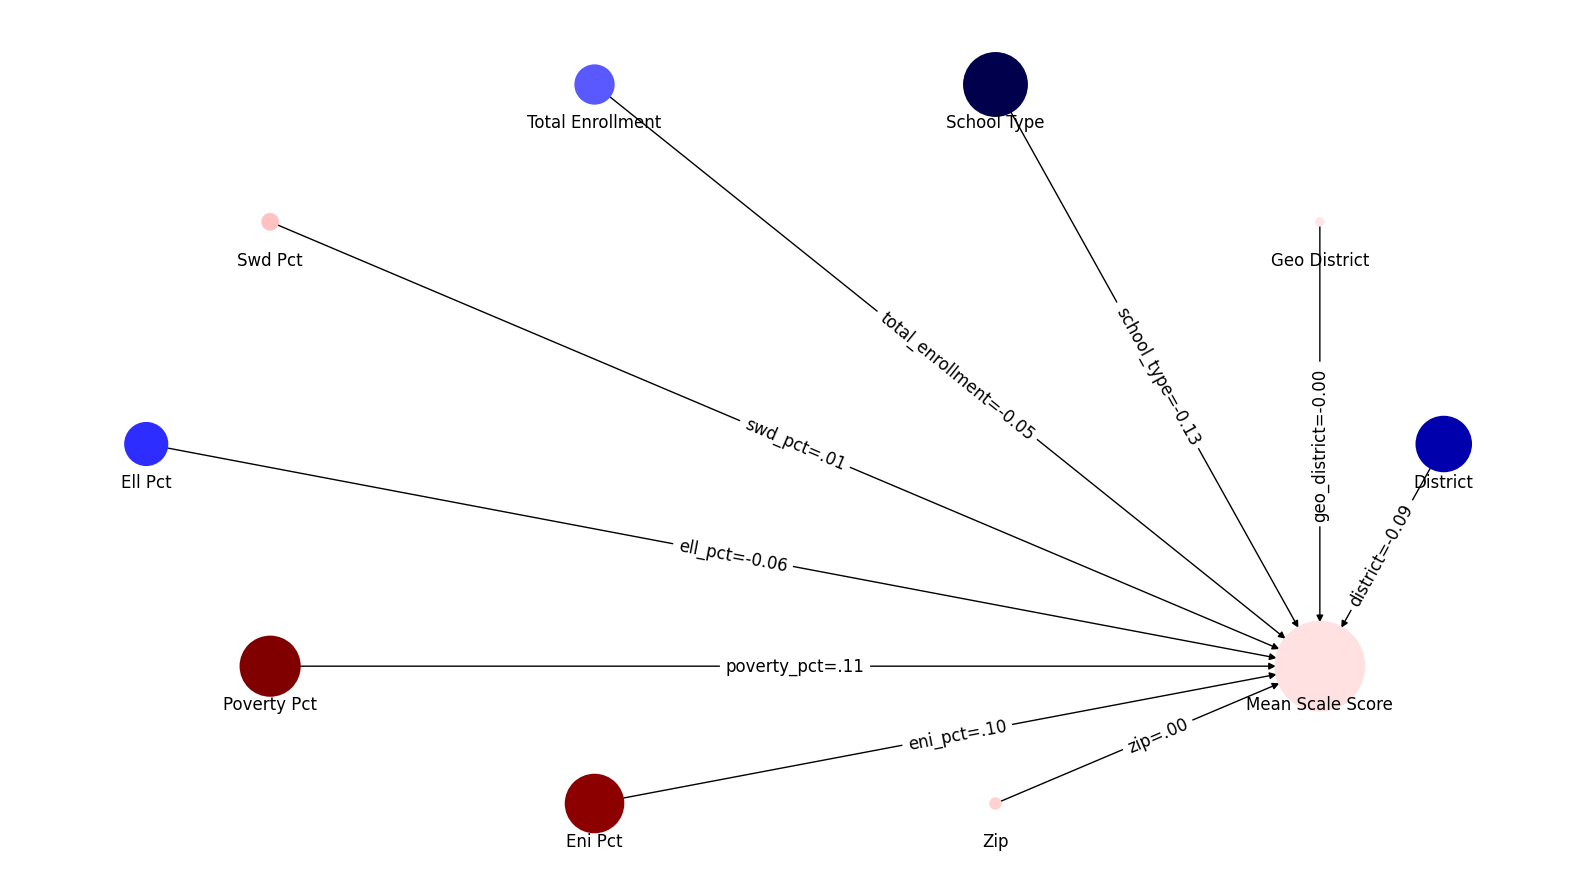

### Graph of OLS coefficients

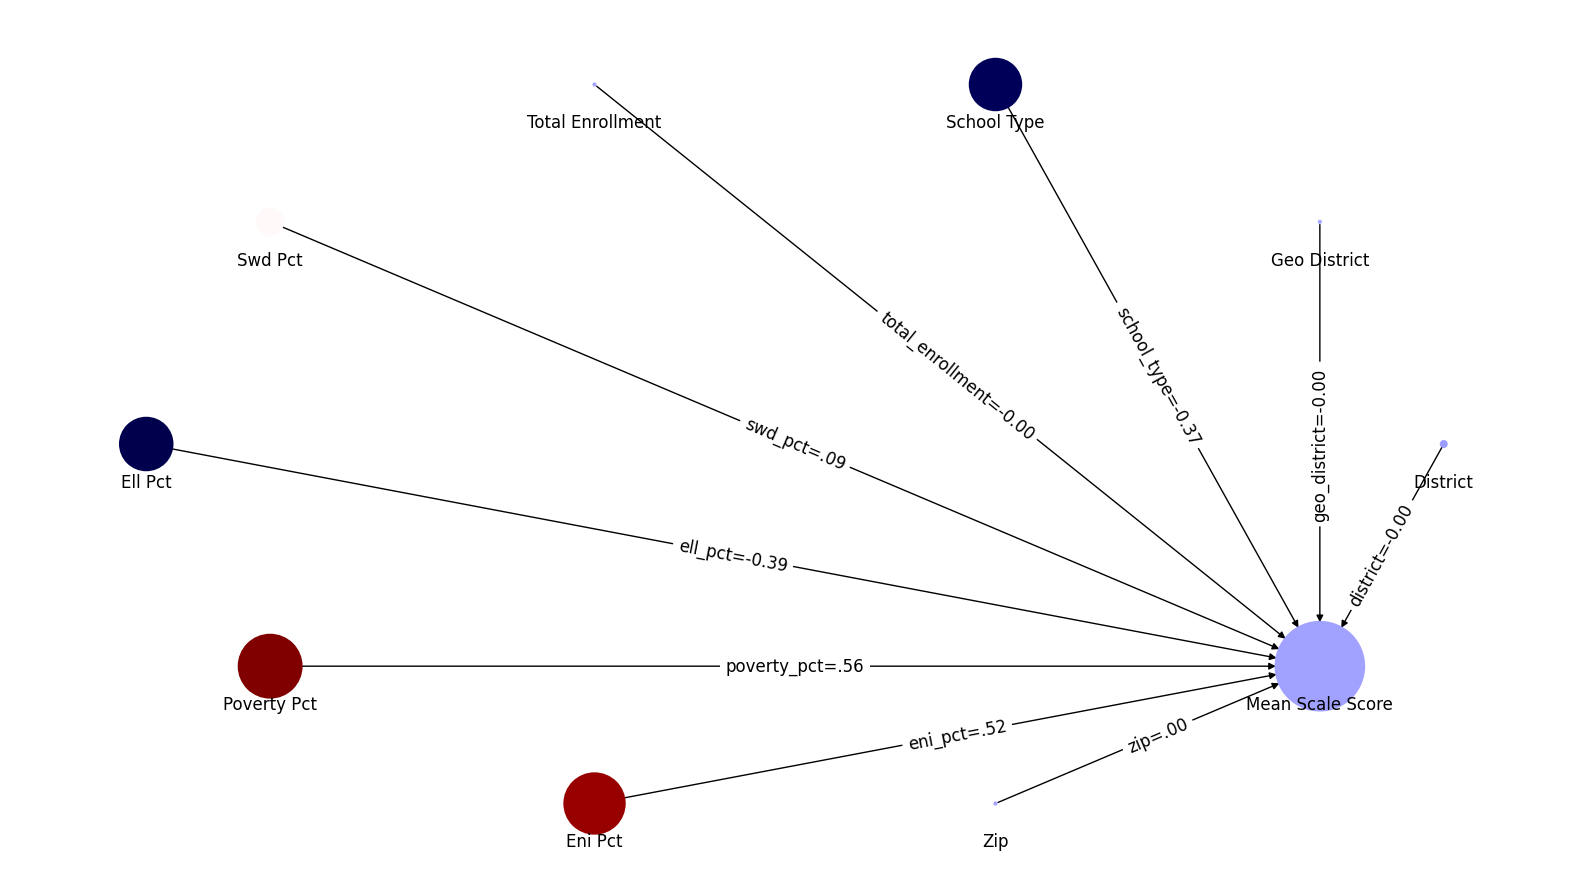

In [82]:
# display(md("### Graph of PLS coefficients"))
coefs = [x[0] for x in pls.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)

display(md("### Graph of OLS coefficients"))
coefs = [x for x in model.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)